####  2세대 도감 만들기 
<hr>
1. 251 마리의 이미지를 받아서 <br>
2. 70 * 70 사이즈로 리사이즈 <br>
3. 컬러로 돌릴 예정   약 4900*3 = 150000 컬럼 예상<br>
4. 이미지 251개를 10배가량 복제할 예정<br>
5. 이미지 처리후, csv에 저장. <br>
<hr>
6. csv로부터 파일을 읽어서 도감 번호를 타겟으로 설정 하여 트레인/테스트<br>
7. 모델 만들기.<br>
8. 여유있으면 웹연결하여 예측모델 만들기.<br>




In [46]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
from rembg import remove #배경 제거

In [54]:
def resize_image(image, width=None, height=None, fx=None, fy=None, interpolation=cv2.INTER_LINEAR):
    """
    cv2.resize()를 활용하여 이미지를 크기 조정하는 함수

    Parameters:
        image (numpy.ndarray): 원본 이미지
        width (int, optional): 새로운 이미지의 너비 (dsize와 함께 사용)
        height (int, optional): 새로운 이미지의 높이 (dsize와 함께 사용)
        fx (float, optional): 가로 크기 비율 (dsize 대신 사용 가능)
        fy (float, optional): 세로 크기 비율 (dsize 대신 사용 가능)
        interpolation (int, optional): 보간법 (기본값 cv2.INTER_LINEAR)

    Returns:
        numpy.ndarray: 크기 조정된 이미지
    """
    if width is not None and height is not None:
        dsize = (width, height)
    else:
        dsize = None  # fx, fy가 사용됨

    resized = cv2.resize(image, dsize=dsize, fx=fx, fy=fy, interpolation=interpolation)
    return resized

In [53]:
def rotate_image(image, angle, center=None, scale=1.0):
    """
    이미지를 특정 각도로 회전하는 함수

    Parameters:
        image (numpy.ndarray): 원본 이미지
        angle (float): 회전 각도 (반시계 방향)
        center (tuple, optional): 회전 중심 좌표 (기본값: 이미지 중앙)
        scale (float, optional): 크기 비율 (기본값: 1.0)

    Returns:
        numpy.ndarray: 회전된 이미지
    """
    (h, w) = image.shape[:2]
    if center is None:
        center = (w // 2, h // 2)  # 중심점을 이미지 중앙으로 설정

    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [52]:
def flip_image(image, flip_code):
    """
    이미지를 뒤집는 함수

    Parameters:
        image (numpy.ndarray): 원본 이미지
        flip_code (int): 0 (상하 뒤집기), 1 (좌우 뒤집기), -1 (상하+좌우 뒤집기)

    Returns:
        numpy.ndarray: 뒤집힌 이미지
    """
    flipped = cv2.flip(image, flip_code)
    return flipped

In [51]:

def remove_background(image):
    """
    rembg를 이용하여 이미지의 배경을 제거하는 함수

    Parameters:
        image (numpy.ndarray): 원본 이미지 (BGR 형식)

    Returns:
        numpy.ndarray: 배경이 제거된 이미지 (RGBA 형식)
    """
    # OpenCV의 이미지를 PIL 이미지로 변환
    import PIL.Image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV 이미지는 BGR이므로 변환 필요
    pil_image = PIL.Image.fromarray(image_rgb)

    # 배경 제거 수행
    output_pil = remove(pil_image)

    # 다시 OpenCV 형식으로 변환 (RGBA 형식 유지)
    output = np.array(output_pil)

    return output

In [49]:
data_dir = './_data/'
img_dir  = './_image/'
alimglist = os.listdir(img_dir)

In [50]:
imglist = [x for x in alimglist if x[5]=='1']


In [78]:
testimg = cv2.imread(img_dir+'009201.png', cv2.IMREAD_GRAYSCALE)

otsu threshold 183.0


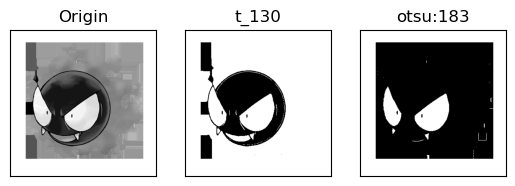

In [79]:
_, t_130 = cv2.threshold(testimg, 110, 255, cv2.THRESH_BINARY)
t, t_otsu = cv2.threshold(testimg, -1, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print('otsu threshold', t)

imgs = {'Origin': testimg, 't_130':t_130, 'otsu:%d'%t: t_otsu}
for i, (key, value) in enumerate(imgs.items()):
    plt.subplot(1,3, i+1)
    plt.title(key)
    plt.imshow(value, cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

In [80]:
blk_size = 9
C = 5
ret, th1 = cv2.threshold(testimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

th2 = cv2.adaptiveThreshold(testimg, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                            cv2.THRESH_BINARY,blk_size,C   )
th3 = cv2.adaptiveThreshold(testimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY,blk_size,C   )

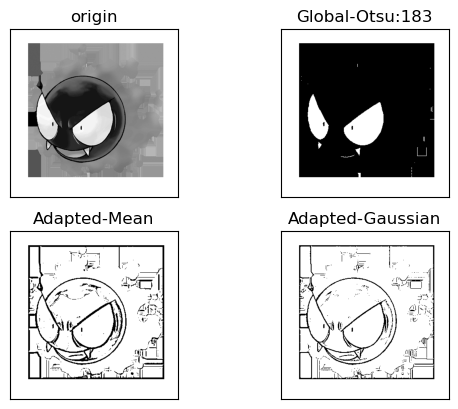

In [81]:
imgs = {'origin': testimg, 'Global-Otsu:%d'%ret:th1,
        'Adapted-Mean':th2, 'Adapted-Gaussian': th3}
for i, (key, value) in enumerate(imgs.items()):
    plt.subplot(2,2, i+1)
    plt.title(key)
    plt.imshow(value, cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()

In [57]:
resultDF = pd.DataFrame(columns=list(range(14701)))
for i in imglist:
    a = cv2.imread(img_dir+i)
    b = remove_background(a)
    c = resize_image(b, 70, 70)
    cv2.imwrite(data_dir+i,c)

KeyboardInterrupt: 